# Exploring Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Let's analyze datav2.csv (combined and cleaned dataset from Kaggle)

In [ ]:
df = pd.read_csv('datav2.csv')
df

,description,job_title
0,apply exclusively working market leading distr...,business analyst
1,btech mtech computer science statistic applied...,data science
2,bachelor master advanced degree experience rea...,data science
3,c # entity framework net wcf ajax jquery angul...,full stack developer
4,minimum 2 3 experience frontend developmentstr...,front end developer
...,...,...
19827,procurement trade customer satisfaction custom...,database engineer
19828,jenkins devops linux docker teamcity ansible l...,devops developer
19829,btech graduate computer science bachelor bette...,data analyst
19830,javascript json rest core java service xslt mi...,java developer


In [ ]:
df['Description'] = df['description']
df.pop('description')
df

,job_title,Description
0,business analyst,apply exclusively working market leading distr...
1,data science,btech mtech computer science statistic applied...
2,data science,bachelor master advanced degree experience rea...
3,full stack developer,c # entity framework net wcf ajax jquery angul...
4,front end developer,minimum 2 3 experience frontend developmentstr...
...,...,...
19827,database engineer,procurement trade customer satisfaction custom...
19828,devops developer,jenkins devops linux docker teamcity ansible l...
19829,data analyst,btech graduate computer science bachelor bette...
19830,java developer,javascript json rest core java service xslt mi...


In [ ]:
df['job_title'].value_counts()

business analyst              1800
java developer                1800
data analyst                  1800
ios developer                 1800
database engineer             1800
software engineer             1800
data science                  1572
devops developer              1203
administrator                  755
full stack developer           718
system engineer                643
android developer              542
cyber security                 530
python developer               454
software developer             394
web developer                  389
mobile developer               330
front end developer            328
machine learning developer     314
react js developer             294
php developer                  294
sql developer                  272
Name: job_title, dtype: int64

In [ ]:
jobs = np.sort(df['job_title'].unique()) #List of all categories array form
df_jobs = [df[df['job_title'] == job].loc[:, ['Description', 'job_title']] for job in jobs] #Create new df with interchanging cols
print(f'{len(jobs)} Jobs: ', jobs)

22 Jobs:  ['administrator' 'android developer' 'business analyst' 'cyber security'
 'data analyst' 'data science' 'database engineer' 'devops developer'
 'front end developer' 'full stack developer' 'ios developer'
 'java developer' 'machine learning developer' 'mobile developer'
 'php developer' 'python developer' 'react js developer'
 'software developer' 'software engineer' 'sql developer'
 'system engineer' 'web developer']


In [ ]:
df_jobs[21]

,Description,job_title
55,apply employer website overview role technical...,web developer
57,apply developer c # developer looking work nam...,web developer
154,apply infrastructure specialist knowledge jbos...,web developer
264,apply established marketing agency seeking dev...,web developer
288,javascript mysql ajax jquery design pattern de...,web developer
...,...,...
19641,analytics content development product manager ...,web developer
19664,apply message body client leading supplier mot...,web developer
19703,bpo international customer service outbound pr...,web developer
19759,apply front developer mad4digital digital mark...,web developer


## Let's see common words of each categories seen from word frequency

In [ ]:
def wordfreq(data):
    count = data['Description'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

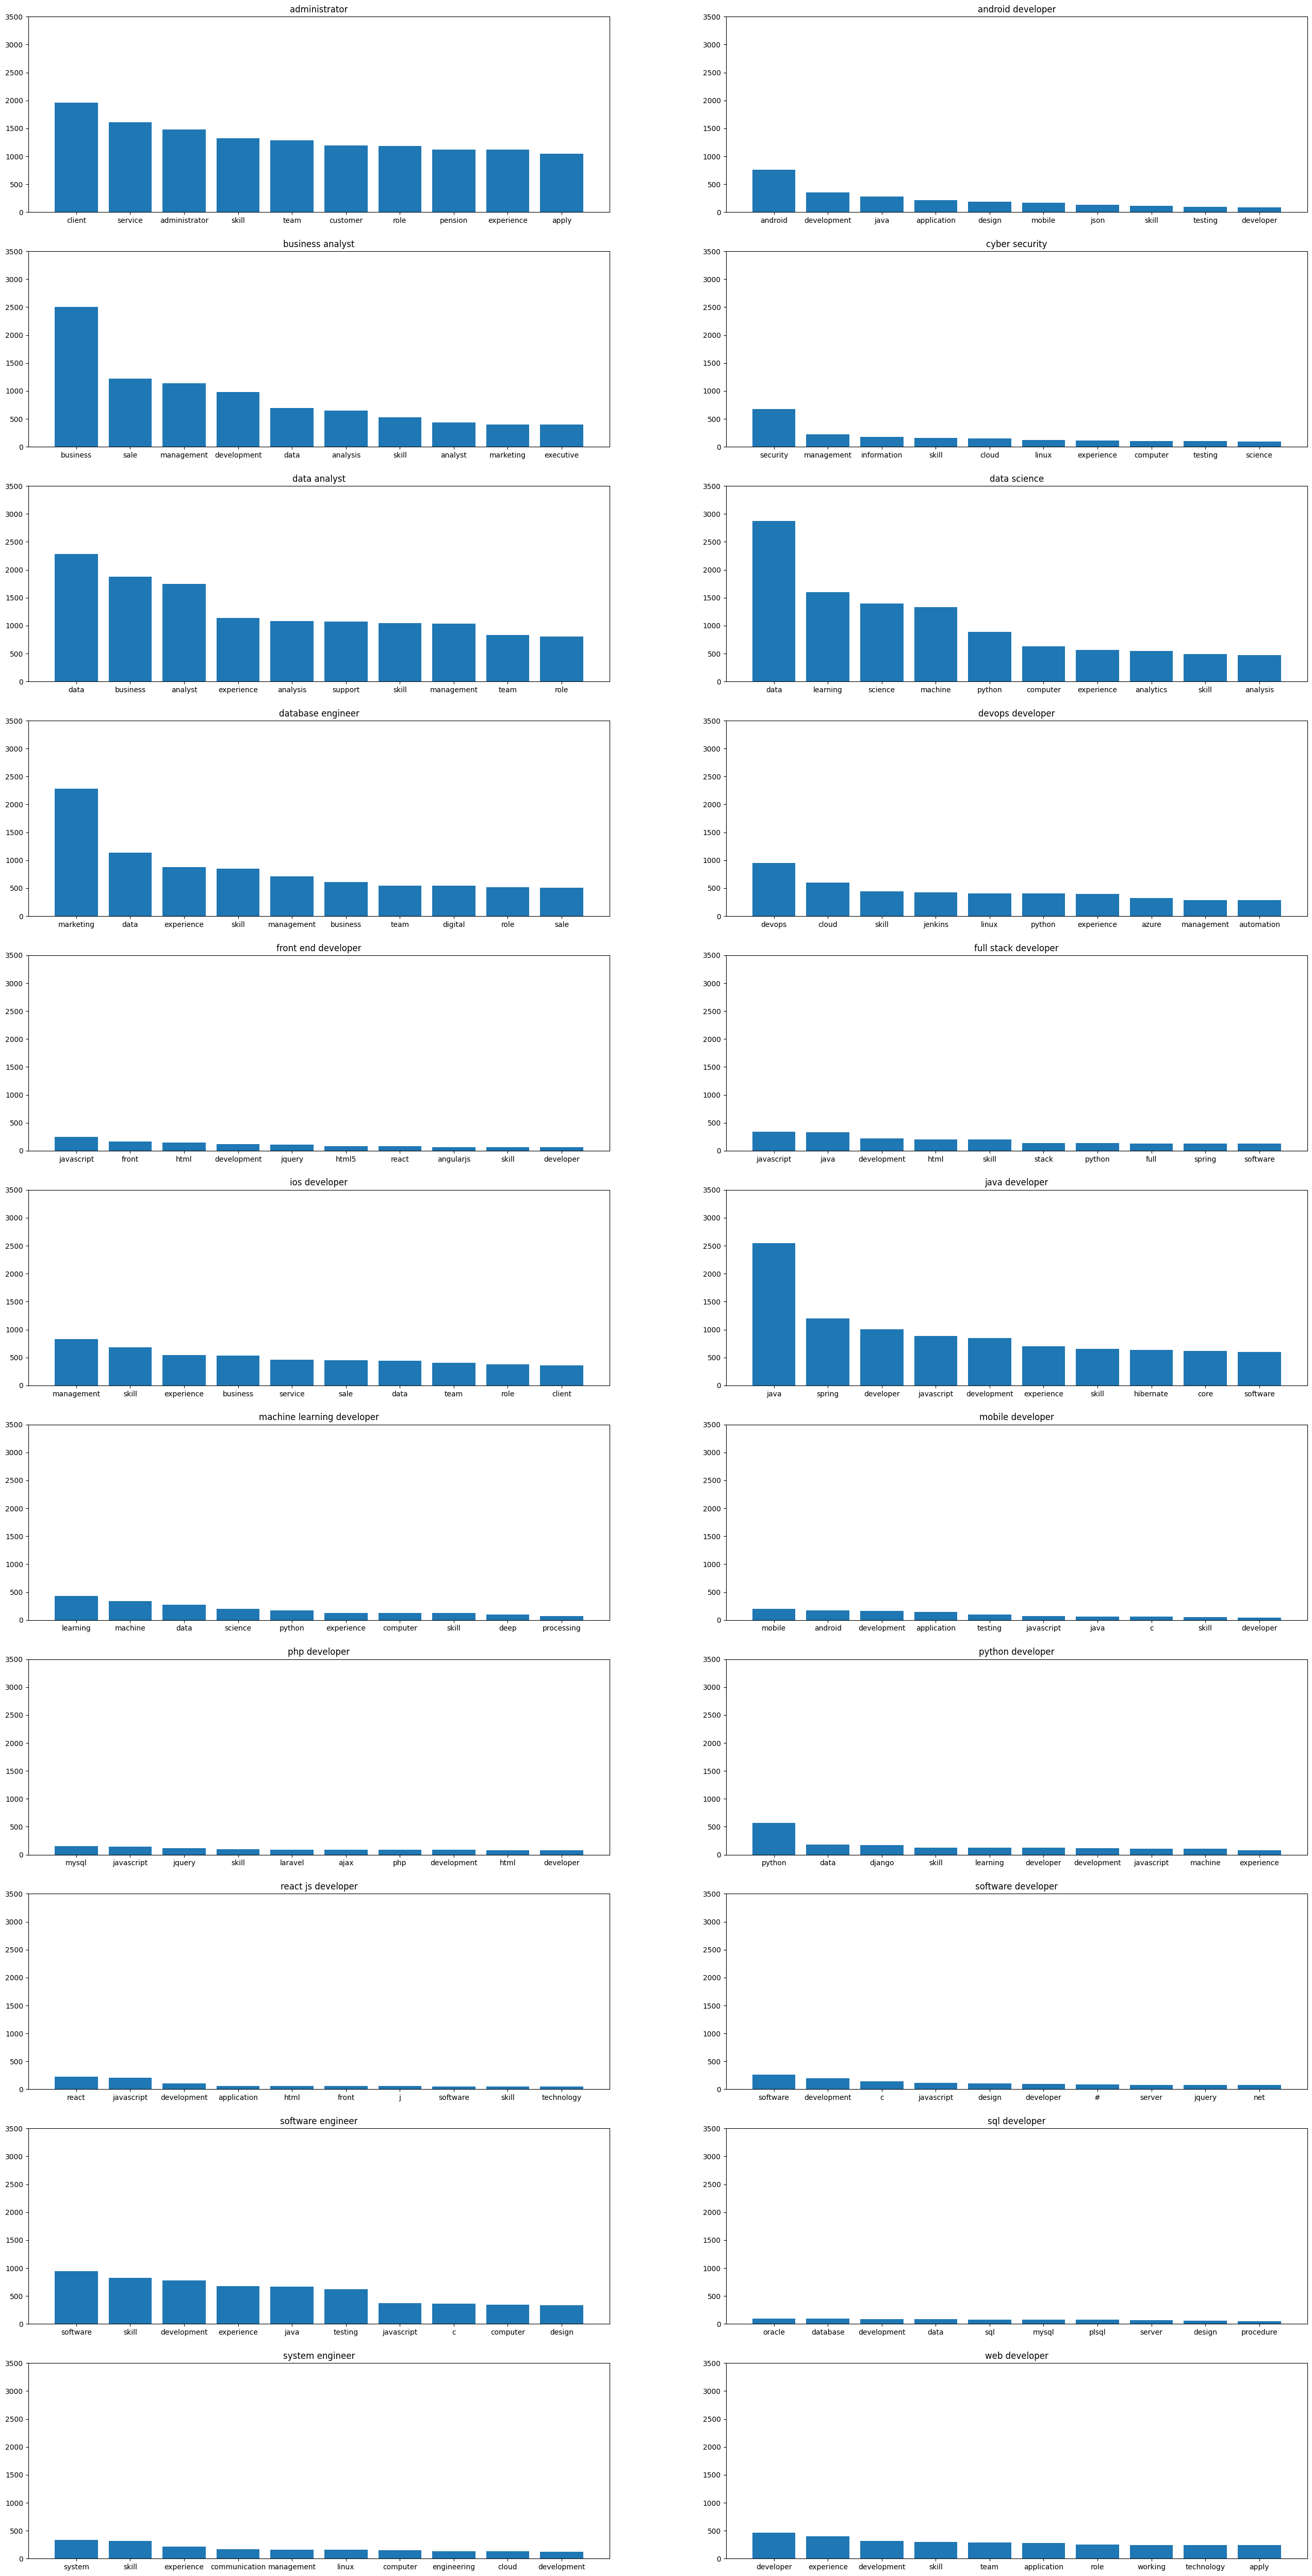

In [ ]:
fig = plt.figure(figsize=(32, 64))

for i, job in enumerate(jobs):
    wf = wordfreq(df_jobs[i])

    fig.add_subplot(11, 2, i + 1).set_title(job)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()

In [ ]:
df.to_csv('CleanResume(datav2).csv', index=False)

# Bulding Model

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
with open("CleanResume(datav2).csv", encoding='utf8') as csvfile: #the csv file is not using the CP1252 encoding so I have to specify,
                                                            #let's try to specify with the commonn encoding='utf8'
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

job_title,Description

Each data point looks like this:

business analyst,apply exclusively working market leading distributor intermediary market seek individual work across central midland region existing contact financial planning firm seek candidate ideally existing contact midland technical expertise within either trust structured product client market leading firm enviable track record market product service respected successful candidate provided market leading salary control diary assistance appointment booking within existing client bank please visit idex consulting website opportunity application successful contact discus opportunity detail within 2 working receiving application application unsuccessful information supplied still retained connection future vacancy overwhelming application response receive various source hear within week please assume application unsuccessful required skill business development sale business development co

In [ ]:
def parse_data_from_file(filename): # Extracts sentences and labels from a CSV file and returns sentences, labels
    sentences = []
    labels = []
    with open(filename, encoding='utf8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentences.append(row[1])

    return sentences, labels

In [ ]:
sentences, labels = parse_data_from_file("CleanResume(datav2).csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words.\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 19832 sentences in the dataset.

First sentence has 106 words.

There are 19832 labels in the dataset.

The first 5 labels are ['business analyst', 'data science', 'data science', 'full stack developer', 'front end developer']


## Some variable for easy adjustement

In [ ]:
MAXLEN = 900
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Let's split the lists of sentences and labels into training and validation

In [ ]:
def train_val_split(sentences, labels, training_split):
    # Compute the number of sentences that will be used for training
    train_size = int(len(labels)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 15865 sentences for training.

There are 15865 labels for training.

There are 3967 sentences for validation.

There are 3967 labels for validation.


## Tokenize

In [ ]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences) # Fit the tokenizer to the training sentences

    return tokenizer

In [ ]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words")
print("with <OOV> token included" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 19023 words
with <OOV> token included


In [ ]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences) # Convert sentence to sequence
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    return padded_sequences

In [ ]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (15865, 900)
Padded validation sequences have shape: (3967, 900)


In [ ]:
# Convert the labels into one-hot
train_label_seq = pd.get_dummies(train_labels)
val_label_seq = pd.get_dummies(val_labels)
val_label_seq

,administrator,android developer,business analyst,cyber security,data analyst,data science,database engineer,devops developer,front end developer,full stack developer,...,machine learning developer,mobile developer,php developer,python developer,react js developer,software developer,software engineer,sql developer,system engineer,web developer
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3963,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3964,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Text classification model

In [ ]:
EMBEDDING_DIM = 32
tf.random.set_seed(123)

### Model and learning rate tuning (for option)

In [ ]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_length=MAXLEN, mask_zero=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(80, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(22, activation='softmax')])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 5))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss='categorical_crossentropy', optimizer=optimizer)

history = model_tune.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq), callbacks=[lr_schedule])

Epoch 1/20
496/496 [==============================] - 62s 110ms/step - loss: 2.8363 - val_loss: 1.8557 - lr: 0.0010
Epoch 2/20
496/496 [==============================] - 29s 58ms/step - loss: 2.0433 - val_loss: 1.5438 - lr: 0.0016
Epoch 3/20
496/496 [==============================] - 22s 44ms/step - loss: 1.7238 - val_loss: 1.3987 - lr: 0.0025
Epoch 4/20
496/496 [==============================] - 18s 37ms/step - loss: 1.5532 - val_loss: 1.3323 - lr: 0.0040
Epoch 5/20
496/496 [==============================] - 18s 35ms/step - loss: 1.4538 - val_loss: 1.2869 - lr: 0.0063
Epoch 6/20
496/496 [==============================] - 16s 33ms/step - loss: 1.3988 - val_loss: 1.2745 - lr: 0.0100
Epoch 7/20
496/496 [==============================] - 15s 30ms/step - loss: 1.3984 - val_loss: 1.2888 - lr: 0.0158
Epoch 8/20
496/496 [==============================] - 16s 33ms/step - loss: 1.3676 - val_loss: 1.2727 - lr: 0.0251
Epoch 9/20
496/496 [==============================] - 15s 30ms/step - loss: 1.3

(0.0001, 10.0, 0.0, 10.0)

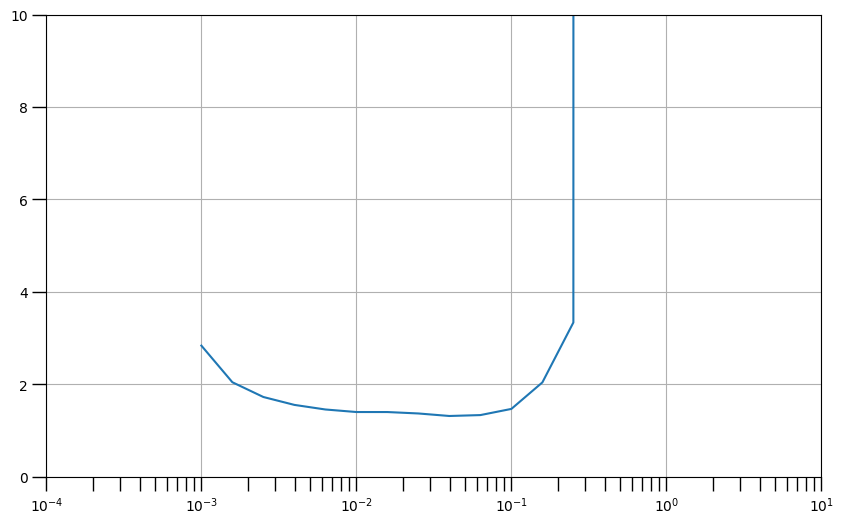

In [ ]:
# Define the learning rate array
lrs = 1e-3 * (10 ** (np.arange(20) / 5))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 10, 0, 10])

### Build model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_length=MAXLEN, mask_zero=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(22, activation='softmax')])

model.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded_seq, train_label_seq, epochs=10, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/10
496/496 [==============================] - 85s 153ms/step - loss: 2.3901 - accuracy: 0.3466 - val_loss: 1.5719 - val_accuracy: 0.5210
Epoch 2/10
496/496 [==============================] - 40s 80ms/step - loss: 1.5619 - accuracy: 0.5305 - val_loss: 1.2651 - val_accuracy: 0.6113
Epoch 3/10
496/496 [==============================] - 28s 56ms/step - loss: 1.2811 - accuracy: 0.6143 - val_loss: 1.1981 - val_accuracy: 0.6423
Epoch 4/10
496/496 [==============================] - 21s 43ms/step - loss: 1.1159 - accuracy: 0.6599 - val_loss: 1.1337 - val_accuracy: 0.6645
Epoch 5/10
496/496 [==============================] - 19s 39ms/step - loss: 1.0148 - accuracy: 0.6884 - val_loss: 1.1134 - val_accuracy: 0.6794
Epoch 6/10
496/496 [==============================] - 21s 43ms/step - loss: 0.9426 - accuracy: 0.7148 - val_loss: 1.1093 - val_accuracy: 0.6892
Epoch 7/10
496/496 [==============================] - 18s 37ms/step - loss: 0.8772 - accuracy: 0.7359 - val_loss: 1.1265 - val_accuracy

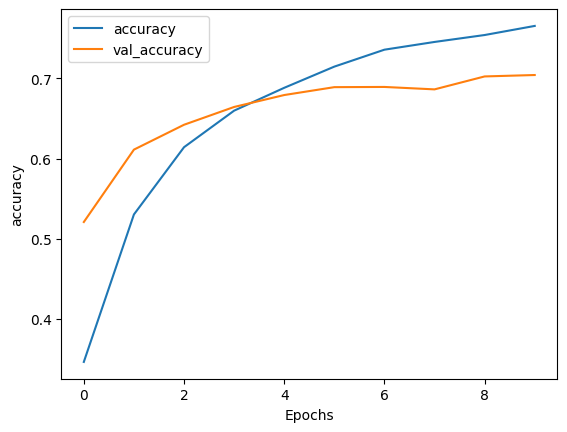

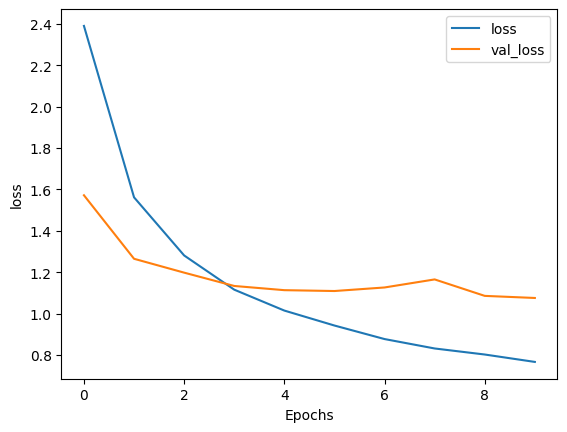

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
sample_text = 'web developer 823 0183 2038 3 year experience field o precisely o web also developed several project company currently looking job not limited absolutely can provide good experience learning support 2016 2017 smk telkom jawa timur r software engleering iml 2020 present stmik ppkia pradnya paramitha jawa timur bachelor informatics system cs e php data entry ce telkom ak jember handle ail incoming supplier network installation register moving data spreadsheet fo e microsoft office web developer visionet data internasional perform maintenance existing application resolve bug ond implement best solution error found overcoming fraud employee absence resulting excessive overtime 01832038 programmer raffli kandos algostudio collaborate teom develop application roffli firmansyah company perform maintenance existing application resolve bug implement best solution error found'

In [ ]:
def predict_category(preprocessed_text):
    resume_seq = tokenizer.texts_to_sequences([preprocessed_text]) # Convert sentence to sequence
    padded_resume = pad_sequences(resume_seq, maxlen=MAXLEN, padding=PADDING)

    predicted_probabilities = model.predict(padded_resume)
    predicted_category = np.argmax(predicted_probabilities)

    predicted_label = jobs[predicted_category]

    return predicted_label

In [ ]:
prediction = predict_category(sample_text)
print(prediction)

1/1 [==============================] - 3s 3s/step
web developer


## Let's try to predict

In [ ]:
import cv2
import pytesseract
from pytesseract import *
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
pytesseract.tesseract_cmd = (r'C:\Users\KEVIN ASUS 516\AppData\Local\Programs\Tesseract-OCR\tesseract.exe')
img_pred = 'CV Raffli_page-0001.jpg'
img = cv2.imread(img_pred)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [ ]:
custom_config = r'--oem 3 --psm 6'

details = pytesseract.image_to_data(image=threshold_img,
                                    output_type=Output.DICT,
                                    config=custom_config,
                                    lang='eng')

In [ ]:
teks_raw = [word.lower() for word in details['text'] if word.isalnum()]
sample_text = ' '.join(teks_raw)
sample_text

In [ ]:
def preprocess(txt):
    # filtering
    txt = re.sub('[%s]' % re.escape("""!"Ã¢â£¬$%&'()*,-./:;<=>?@[\]^_`{|}~"""), ' ', txt)  # remove punctuations except # and + for word like C++ or C#
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace

    # remove stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "required", "be", "because", "skills", "managed","management", "manage", "manager","skill", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
    result = []
    words = txt.split()
    for w in words:
        if w not in stopwords:
            result.append(w)

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    txt = [lemmatizer.lemmatize(w) for w in result]

    return ' '.join(txt)

In [ ]:
def predict_category(resume_text):
    preprocessed_text = preprocess(resume_text)

    resume_seq = tokenizer.texts_to_sequences([preprocessed_text]) # Convert sentence to sequence
    padded_resume = pad_sequences(resume_seq, maxlen=MAXLEN, padding=PADDING)

    predicted_probabilities = model.predict(padded_resume)
    predicted_category = np.argmax(predicted_probabilities)

    predicted_label = jobs[predicted_category]

    return predicted_label

In [ ]:
prediction = predict_category(sample_text)
print(prediction)

In [ ]:
model.save("ModelCV(v2).h5")